In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

In [2]:
filename = 'D1.txt'
D1 = pd.read_csv(filename, sep=' ', header=None)
D1.columns = ['x1', 'x2', 'y']

In [3]:
def entropy(data):
    if len(data) == 0:
        return 0
    d0 = len(data[data.loc[:, 'y'] == 0])
    d1 = len(data[data.loc[:, 'y'] == 1])
    p0 = d0/len(data)
    p1 = d1/len(data)
    if (p0 == 0) or (p1 == 0):
        H = 0 
    else:
        H = -p0 * math.log(p0, 2)- p1 * math.log(p1, 2)
    return H

In [4]:
def entropy_feature(len_left, len_right):
    p_l = len_left / (len_left + len_right)
    p_r = len_right / (len_left + len_right)
    if (p_l == 0) or (p_r == 0):
        H = 0 
    else:
        H = -p_l * math.log(p_l, 2)- p_r * math.log(p_r, 2)
    return H

In [5]:
def InfoGain(data, threshold, feature): 
    if len(data) == 0:
        return 0
    Data = data[[feature, 'y']]
    D_left = Data[Data[feature] >= threshold]
    D_right = Data[Data[feature] < threshold]
    p_left = len(D_left)/len(data)
    p_right = len(D_right)/len(data)
    HY = entropy(data)
    entropy_left = entropy(D_left)
    entropy_right = entropy(D_right)
    Gain = HY-(p_left * entropy_left + p_right * entropy_right)
    return Gain, len(D_left), len(D_right)

In [6]:
def GainRatio(data, threshold, feature):
    info_gain, len_left, len_right = InfoGain(data, threshold, feature)
    if info_gain == 0:
        return 0
    split_entropy = entropy_feature(len_left, len_right)
    return info_gain / split_entropy

In [7]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        if self.value is not None:
            isleaf = True
        else:
            isleaf = False
        return isleaf

In [8]:
def decision_tree(data):
    if len(data) == 0:
        return TreeNode(value=1)
    
    if entropy(data) == 0:
        return TreeNode(value=data.iloc[0]['y'])
        
    best_gain_ratio = -math.inf
    best_feature = None
    best_threshold = None
    
    for feature in ['x1', 'x2']:
        thresholds = sorted(data[feature].unique())
        for i in range(len(thresholds) - 1):
            threshold = (thresholds[i] + thresholds[i+1]) / 2
            gain_ratio = GainRatio(data, threshold, feature)
            if gain_ratio > best_gain_ratio:
                best_gain_ratio = gain_ratio
                best_feature = feature
                best_threshold = threshold
    
    if best_gain_ratio == 0:
        if len(data[data['y'] == 1]) >= len(data[data['y'] == 0]):
            return TreeNode(value=1)
        else:
            return TreeNode(value=0)
    
    left_data = data[data[best_feature] >= best_threshold]
    right_data = data[data[best_feature] < best_threshold]
    
    left_tree = decision_tree(left_data)
    right_tree = decision_tree(right_data)
    
    return TreeNode(best_feature, best_threshold, left_tree, right_tree)

In [9]:
def predict(node, sample):
    if node.is_leaf_node():
        return node.value
    if sample[node.feature] >= node.threshold:
        return predict(node.left, sample)
    return predict(node.right, sample)

In [10]:
def plot_decision_boundary(data, tree):
    x_min, x_max = data['x1'].min(), data['x1'].max()
    y_min, y_max = data['x2'].min(), data['x2'].max()
    d = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max + d, d),
                         np.arange(y_min, y_max + d, d))

    Z = np.array([predict(tree, {'x1': x_val, 'x2': y_val}) 
                  for x_val, y_val in zip(np.ravel(xx), np.ravel(yy))])

    Z = Z.reshape(xx.shape)

    cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_points = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.4)
    plt.scatter(data['x1'], data['x2'], c=data['y'], s=20, cmap=cmap_points, edgecolor='k', marker='o')
    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.show()
    return fig

In [16]:
def print_tree(data, node, space=""):
    pos_count = len(data[data['y'] == 1])
    neg_count = len(data[data['y'] == 0])
    
    if node.is_leaf_node():
        print(space + f"y = {node.value} [{'+{}'.format(pos_count)}, {'-{}'.format(neg_count)}]")
    else:
        print(space + f"[{'+{}'.format(pos_count)}, {'-{}'.format(neg_count)}] If {node.feature} >= {node.threshold} then ")
        
        left_data = data[data[node.feature] >= node.threshold]
        print_tree(left_data, node.left, space + "    ")
        
        print(space + "else")
        right_data = data[data[node.feature] < node.threshold]
        print_tree(right_data, node.right, space + "    ")

C:\Users\jzhu254\AppData\Local\Temp/ipykernel_23920/3978332142.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


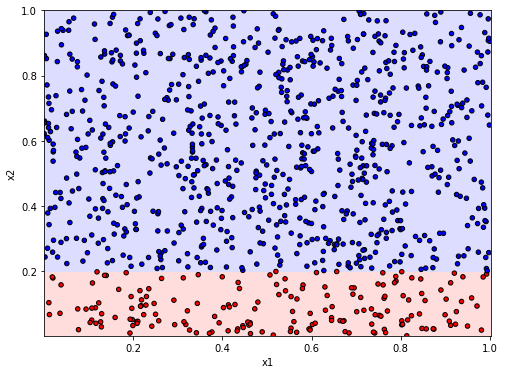

In [13]:
filename = 'D1.txt'
D1 = pd.read_csv(filename, sep=' ', header=None)
D1.columns = ['x1', 'x2', 'y']
filename = 'D2.txt'
D2 = pd.read_csv(filename, sep=' ', header=None)
D2.columns = ['x1', 'x2', 'y']

tree1 = decision_tree(D1)
fig1 = plot_decision_boundary(D1, tree1)
fig1.show()

[+492, -508] If x1 >= 0.53287 then 
    [+372, -109] If x2 >= 0.2271305 then 
        [+343, -23] If x2 >= 0.4231365 then 
            y = 1.0 [+278, -0]
        else
            [+65, -23] If x1 >= 0.7078145 then 
                y = 1.0 [+55, -0]
            else
                [+10, -23] If x2 >= 0.319787 then 
                    [+10, -8] If x1 >= 0.591909 then 
                        [+10, -3] If x1 >= 0.633785 then 
                            y = 1.0 [+7, -0]
                        else
                            [+3, -3] If x2 >= 0.39185400000000004 then 
                                y = 1.0 [+3, -0]
                            else
                                y = 0.0 [+0, -3]
                    else
                        y = 0.0 [+0, -5]
                else
                    y = 0.0 [+0, -15]
    else
        [+29, -86] If x1 >= 0.8869705 then 
            [+26, -6] If x2 >= 0.025887 then 
                [+26, -2] If x2 >= 0.08062749999999999 then 
         

C:\Users\jzhu254\AppData\Local\Temp/ipykernel_23920/1399461479.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


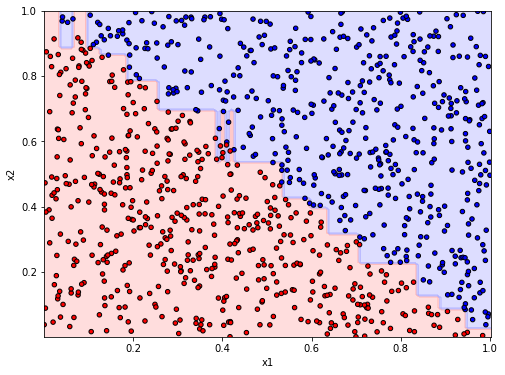

In [17]:
tree2 = decision_tree(D2)
fig2 = plot_decision_boundary(D2, tree2)
fig2.show()
print_tree(D2, tree2)

In [15]:
fig1.savefig('Q6_D1_boundary.png')
fig2.savefig('Q6_D2_boundary.png')